In [1]:
import argparse
import math
from pathlib import Path
import matplotlib
import torch
from torch.optim.lr_scheduler import StepLR
from SymNet import polypde
from SymNet.model_helper import *
import scvelo as scv
import scanpy
import scipy
import re
from torch.utils.data import DataLoader
from VeloAe.util import estimate_ld_velocity
from VeloAe.veloproj import *
from VeloAe.model import *
from VeloAe.eval_util import evaluate
from utils import PairsDataset, print_eqs, get_state_change_vector, SinkhornDistance
import matplotlib.pyplot as plt


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '5e-6',
                               '--n-epochs', '20000',
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--output', './pretrain_model/',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', ':2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "X",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
device = torch.device("cuda" + args.device if torch.cuda.is_available() else "cpu")
seed = args.seed
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
Path(args.output).mkdir(parents=True,exist_ok=True)

In [4]:
adata = scv.read('./data/DentateGyrus/DentateGyrus.h5ad')
cluster_edges = [("OPC", "OL"), ("nIPC", "Neuroblast"), ("Neuroblast", "Granule immature"),
                         ("Granule immature", "Granule mature"), ("Radial Glia-like", "Astrocytes")]
k_cluster = "clusters"
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


pretrain veloAE

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.DoubleTensor(spliced).to(device)
    tensor_u = torch.DoubleTensor(unspliced).to(device)
    tensor_x = torch.DoubleTensor(adata.X.toarray()).to(device)
    model, _ = init_model(adata, args, device)
    model = model.to(device, dtype=torch.float64)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_x  

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 2.938775
Train Epoch: 200/20000 	Loss: 2.448356
Train Epoch: 300/20000 	Loss: 2.143807
Train Epoch: 400/20000 	Loss: 1.910724
Train Epoch: 500/20000 	Loss: 1.756903
Train Epoch: 600/20000 	Loss: 1.652432
Train Epoch: 700/20000 	Loss: 1.569775
Train Epoch: 800/20000 	Loss: 1.505403
Train Epoch: 900/20000 	Loss: 1.443779
Train Epoch: 1000/20000 	Loss: 1.400930
Train Epoch: 1100/20000 	Loss: 1.355672
Train Epoch: 1200/20000 	Loss: 1.334644
Train Epoch: 1300/20000 	Loss: 1.329191
Train Epoch: 1400/20000 	Loss: 1.308574
Train Epoch: 1500/20000 	Loss: 1.300542
Train Epoch: 1600/20000 	Loss: 1.292103
Train Epoch: 1700/20000 	Loss: 1.285048
Train Epoch: 1800/20000 	Loss: 1.277483
Train Epoch: 

Train Epoch: 19700/20000 	Loss: 1.254228
Train Epoch: 19800/20000 	Loss: 1.264896
Train Epoch: 19900/20000 	Loss: 1.257318
Train Epoch: 20000/20000 	Loss: 1.253331


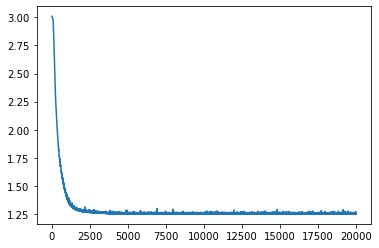

In [6]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

eval

In [14]:
def exp(adata, exp_metrics):
    model, _ = init_model(adata, args, device)
    model.load_state_dict(torch.load(os.path.join(args.output,args.model_name)))
    model = model.to(device, dtype=torch.float64)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=                                     [k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save=args.output + 'dentategyrus_veloae.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    return exp_metrics

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/64 cores)



    finished (0:00:02) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./pretrain_model/dentategyrus_veloae.png


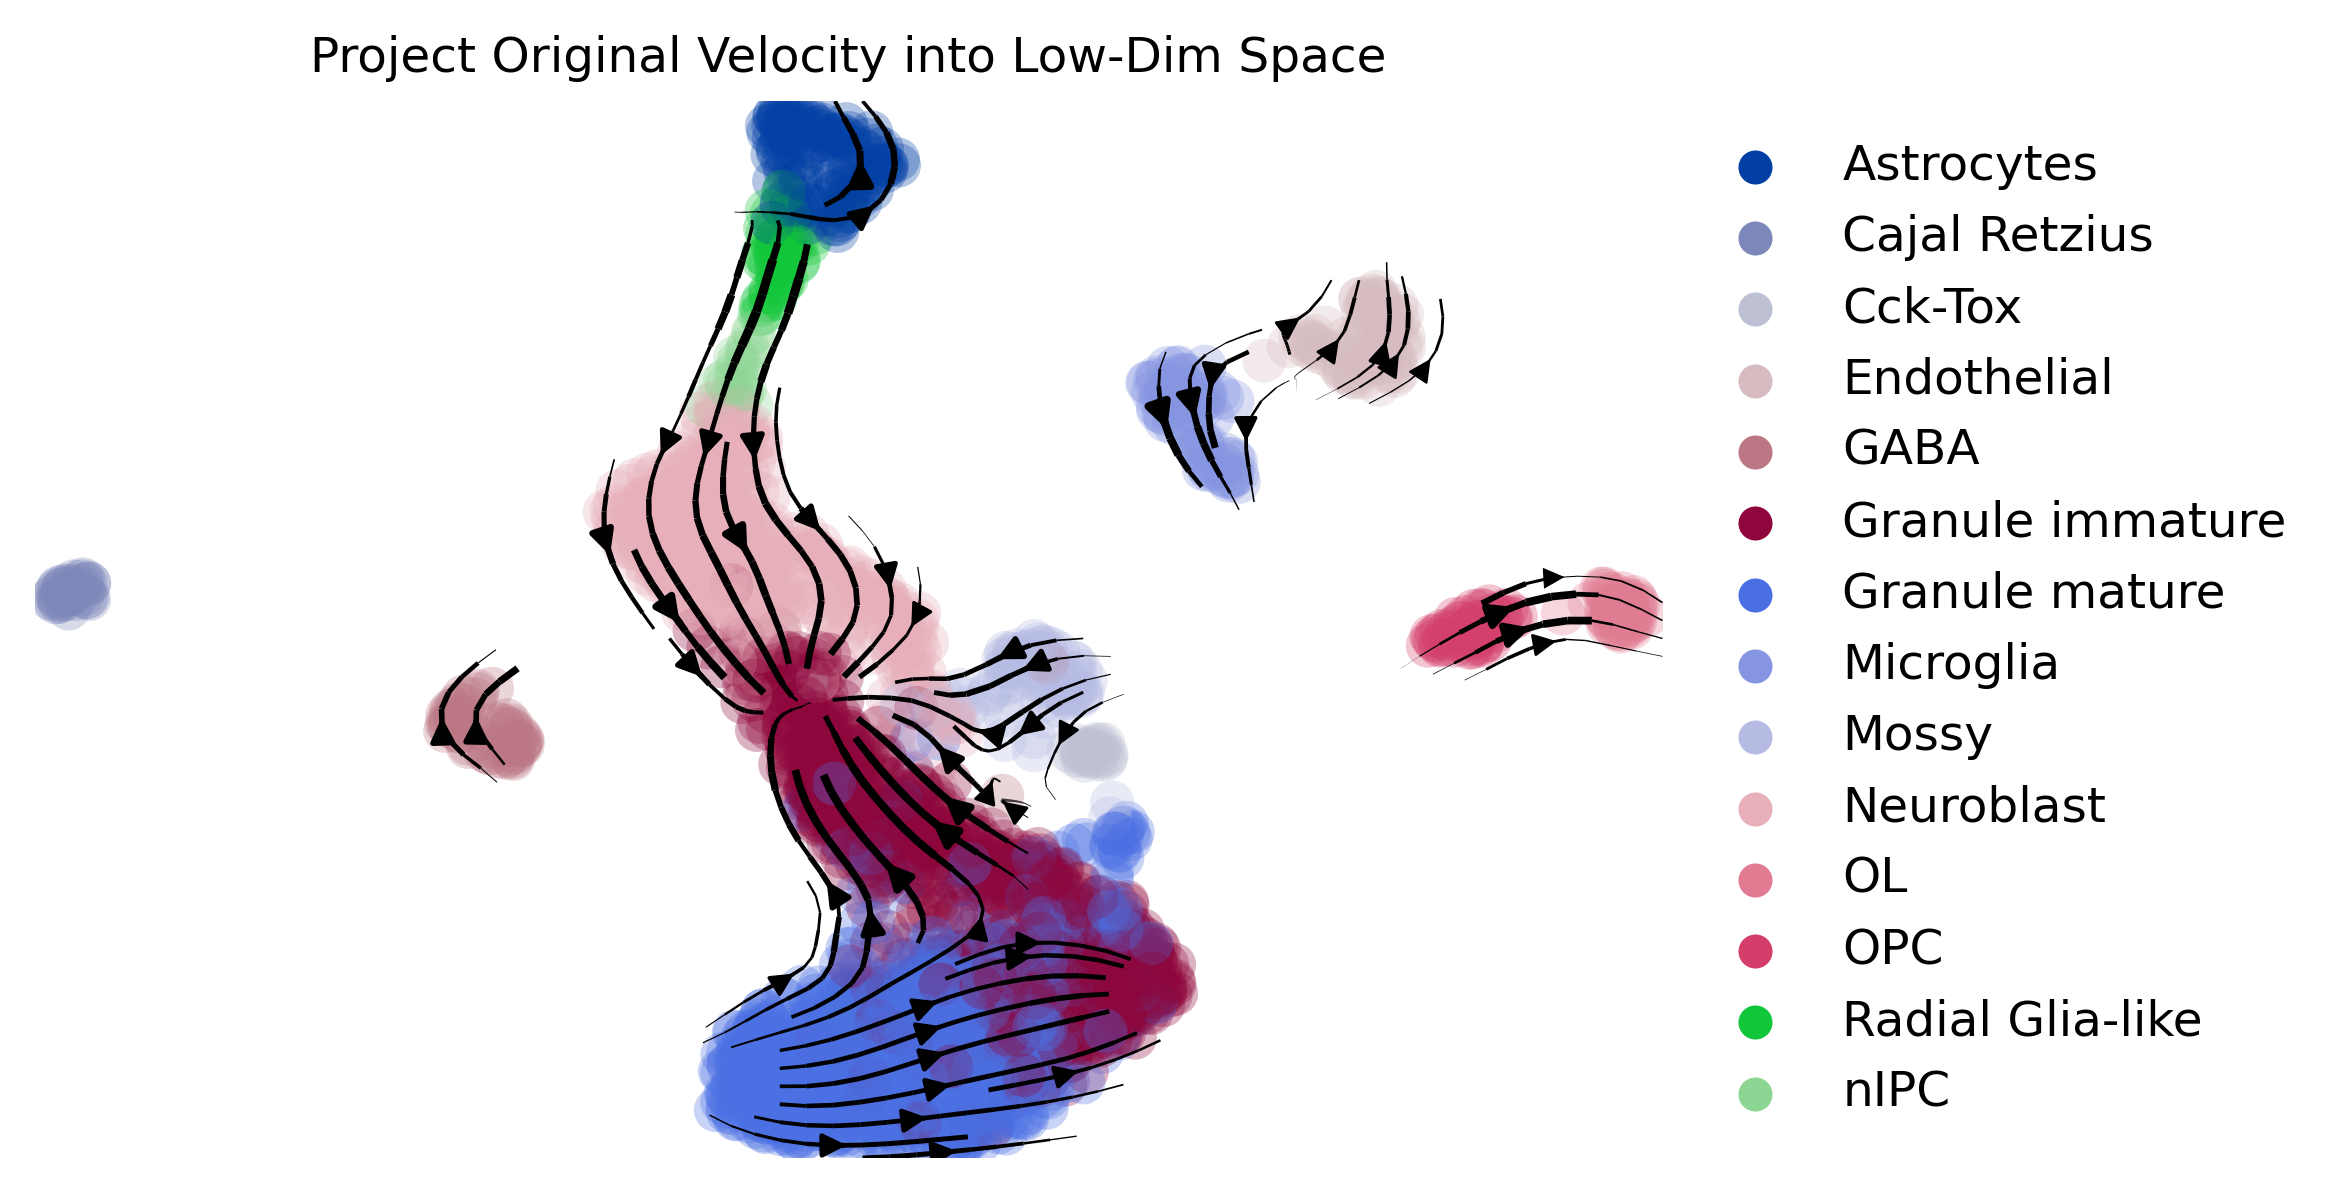

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.97410244, ('nIPC', 'Neuroblast'): 0.97365135, ('Neuroblast', 'Granule immature'): 0.70953476, ('Granule immature', 'Granule mature'): 0.28052086, ('Radial Glia-like', 'Astrocytes'): 0.34132975}
Total Mean: 0.6558278799057007
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.9999973389548452, ('nIPC', 'Neuroblast'): 0.9999968255473995, ('Neuroblast', 'Granule immature'): 0.9999959565072044, ('Granule immature', 'Granule mature'): 0.9999982300520225, ('Radial Glia-like', 'Astrocytes'): 0.9999980288890059}
Total Mean: 0.9999972759900955
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.8159377494135034, ('nIPC', 'Neuroblast'): 0.925060346506998, ('Neuroblast', 'Granule immature'): 0.4838921594606583, ('Granule immature', 'Granule mature'): -0.311498310330227

In [15]:
exp_metrics = {}
result = exp(adata,exp_metrics)